# 6 GLMの応用範囲をひろげる -ロジスティック回帰など-

In [1]:
using CSV
using DataFrames
using Distributions
using GLM
using LaTeXStrings
using LinearAlgebra
using Plots
using StatsBase

## 6.2 例題 : 上限のあるカウントデータ

In [2]:
df = CSV.read("data/section6a.csv");

In [3]:
disallowmissing!(df)

,N,y,x,f
,Int64,Int64,Float64,String
1,8,1,9.76,C
2,8,6,10.48,C
3,8,5,10.83,C
4,8,6,10.94,C
5,8,1,9.37,C
6,8,1,8.81,C
7,8,3,9.49,C
8,8,6,11.02,C
9,8,0,7.97,C


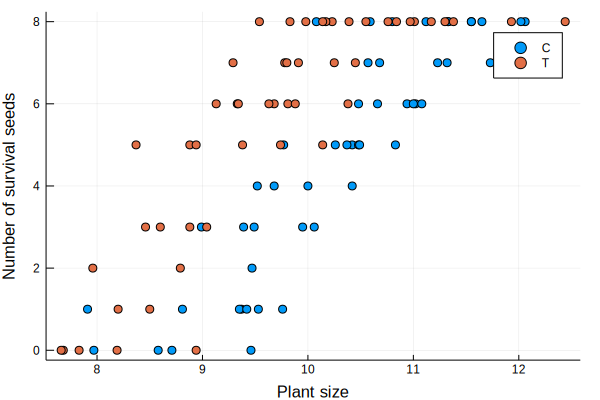

In [4]:
plot(df.x, df.y, group = df.f, seriestype = :scatter, xlabel = "Plant size", ylabel = "Number of survival seeds")

In [5]:
describe(df)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Nothing,DataType
1,N,8.0,8,8.0,8,,,Int64
2,y,5.08,0,6.0,8,,,Int64
3,x,9.9672,7.66,9.965,12.44,,,Float64
4,f,,C,,T,2,,String


## 6.3 二項分布で表現する「あり・なし」カウントデータ
https://juliastats.github.io/Distributions.jl/latest/univariate.html#Distributions.Binomial

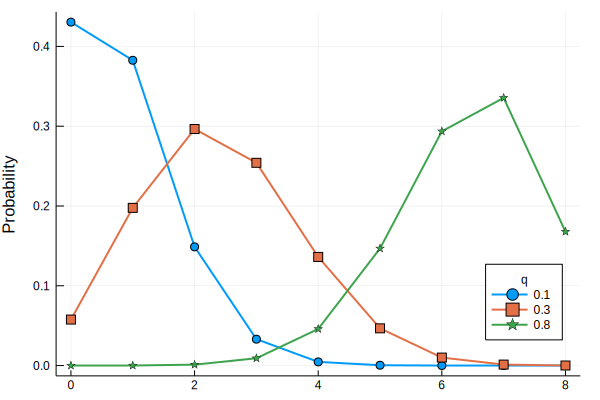

In [6]:
xx = 0:8
plt = plot(ylabel = "Probability")
for x = [0.1, 0.3, 0.8]
    yy = pdf.(Binomial(8, x), xx)
    plot!(xx, yy, lw = 2, label = x, markershape = :auto,
        legendtitle = "q", legend = :bottomright)
end
display(plt)

## 6.4 ロジスティック回帰とロジットリンク関数

In [7]:
function logistic(z)
    1 / (1 + exp(-z))
end

logistic (generic function with 1 method)

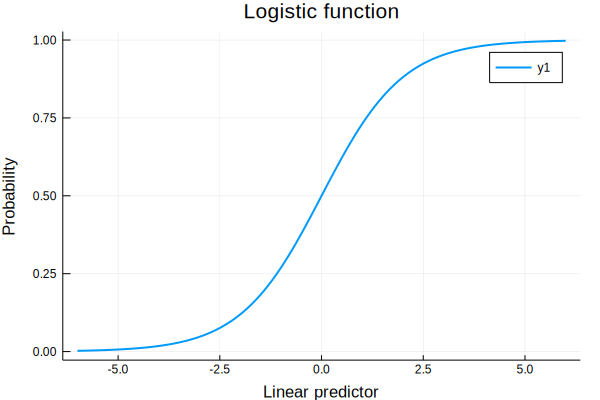

In [8]:
z = -6:0.1:6
plot(z, logistic.(z), lw = 2,title = "Logistic function", xlabel = "Linear predictor", ylabel = "Probability")

### 6.4.2 パラメータ推定
Juliaでは、Binomial分布の場合、応答変数はfractionにしなければならない  
https://github.com/JuliaStats/GLM.jl/issues/228#issuecomment-387340111

In [9]:
df.yy = df.y ./ df.N
df.N = convert(Array{Float64}, df.N)
result = glm(@formula(yy ~ x + f), df, Binomial(), wts = df.N)

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: yy ~ 1 + x + f

Coefficients:
             Estimate Std.Error  z value Pr(>|z|)
(Intercept)  -19.5361   1.41331 -13.8229   <1e-42
x             1.95241  0.138827  14.0636   <1e-44
f: T          2.02151  0.231233  8.74227   <1e-17


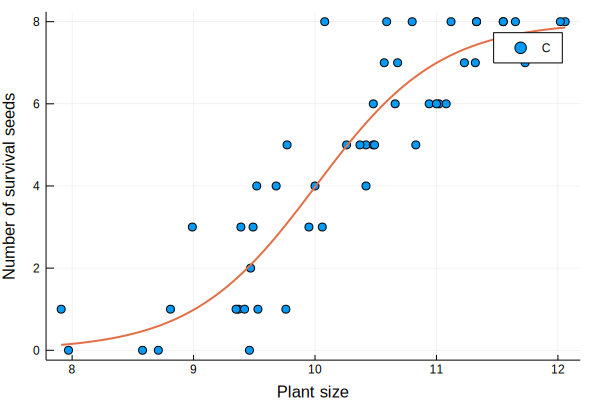

In [10]:
dfc = df[df.f .== "C", :];
plot(dfc.x, dfc.y, seriestype = :scatter, label = "C")
xx = DataFrame(x = range(minimum(dfc.x), maximum(dfc.x), length = 100), f = "C")
yy = predict(result, xx) * 8.0
plot!(xx.x, yy, lw = 2,label = "", xlabel = "Plant size", ylabel = "Number of survival seeds")

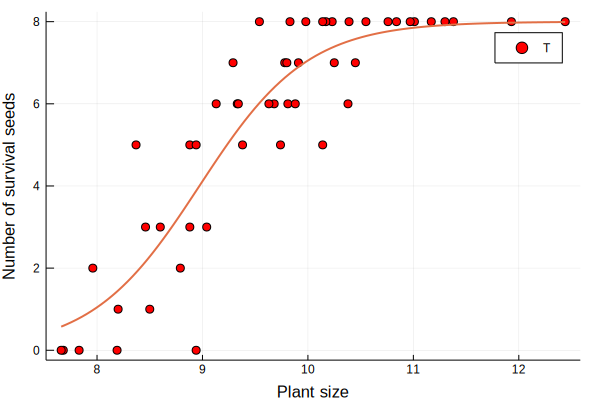

In [11]:
dft = df[df.f .== "T", :];
plot(dft.x, dft.y, seriestype = :scatter, label = "T", color = :red)
xx = DataFrame(x = range(minimum(dft.x), maximum(dft.x), length = 100), f = "T")
yy = predict(result, xx) * 8.0
plot!(xx.x, yy, lw = 2, label = "", xlabel = "Plant size", ylabel = "Number of survival seeds")

In [12]:
typeof(result)

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

### 6.4.4 ロジスティック回帰のモデル選択
$k, \log L^*, $deriance$ - 2\log L^*$, residual deviance, AIC

In [13]:
function model_selection_table(result)
    dof(result), loglikelihood(result), -2loglikelihood(result), deviance(const_model), aic(result)
end

model_selection_table (generic function with 1 method)

In [14]:
const_model = glm(@formula(yy ~ 1), df, Binomial(), wts = df.N)
model_selection_table(const_model)

(1, -321.204670831189, 642.409341662378, 499.23210267844786, 644.409341662378)

In [15]:
f_model = glm(@formula(yy ~ 1 + f), df, Binomial(), wts = df.N)
model_selection_table(f_model)

(2, -316.8798767283339, 633.7597534566678, 499.23210267844786, 637.7597534566678)

In [16]:
x_model = glm(@formula(yy ~ 1 + x), df, Binomial(), wts = df.N)
model_selection_table(x_model)

(2, -180.17272164185795, 360.3454432837159, 499.23210267844786, 364.3454432837159)

In [17]:
xf_model = glm(@formula(yy ~ 1 + x + f), df, Binomial(), wts = df.N)
model_selection_table(xf_model)

(3, -133.1055646426136, 266.2111292852272, 499.23210267844786, 272.2111292852272)

## 6.5 交互作用項の入った線形予測子

In [18]:
interaction_model = glm(@formula(yy ~ x + f + x * f), df, Binomial(), wts = df.N)

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: yy ~ 1 + x + f + x & f

Coefficients:
               Estimate Std.Error    z value Pr(>|z|)
(Intercept)    -18.5233   1.88592   -9.82192   <1e-22
x               1.85251  0.185555    9.98361   <1e-22
f: T         -0.0637455   2.70222 -0.0235901   0.9812
x & f: T       0.216335   0.27993   0.772819   0.4396


In [19]:
model_selection_table(interaction_model)

(4, -132.80529836304297, 265.61059672608593, 499.23210267844786, 273.61059672608593)

## 6.6 割算値の統計モデリングはやめよう
### 6.6.1 割算値いらずのオフセット項わざ

In [20]:
df_population = CSV.read("data/section6b.csv")

,y,x,A
,Int64⍰,Float64⍰,Float64⍰
1,57,0.68,10.3
2,64,0.27,15.6
3,49,0.46,10.0
4,64,0.45,14.9
5,82,0.74,14.0
6,29,0.15,9.6
7,37,0.5,11.8
8,33,0.57,6.8
9,61,0.79,11.8


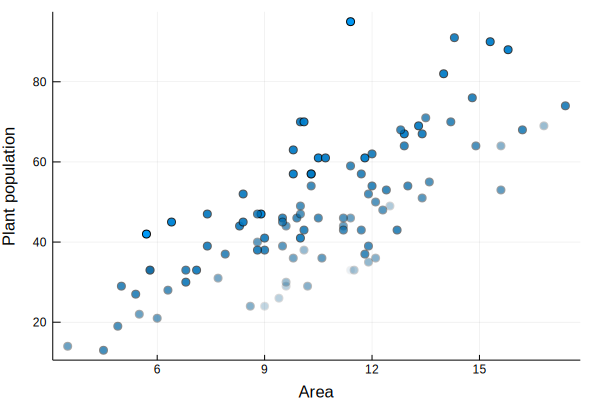

In [21]:
plot(df_population.A, df_population.y, seriestype = :scatter, 
    markeralpha = df_population.x, label = "",
    xlabel = "Area", ylabel = "Plant population")

In [22]:
population_reseult = glm(@formula(y ~ x), df_population, Poisson(), offset = log.(df_population.A))

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},LogLink},DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + x

Coefficients:
             Estimate Std.Error z value Pr(>|z|)
(Intercept)  0.973082 0.0450494 21.6003   <1e-99
x             1.03827 0.0776913  13.364   <1e-40


### 明るさごとの平均個体数の予測

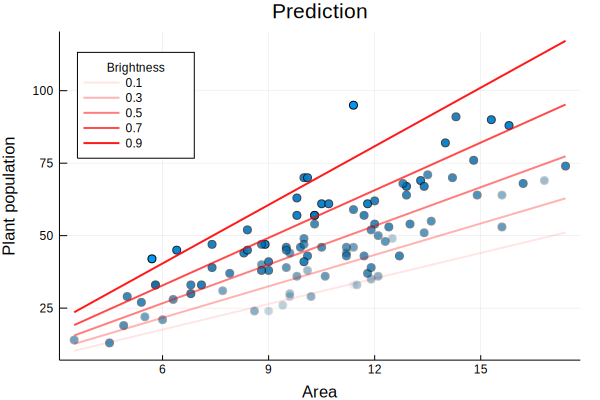

In [23]:
plt = plot(df_population.A, df_population.y, seriestype = :scatter, 
    markeralpha = df_population.x, label = "", 
    title = "Prediction",
    xlabel = "Area", ylabel = "Plant population",
    legendtitle = "Brightness", legend=:topleft)
for j = 0.1:0.2:0.9
    xx = DataFrame(A = range(minimum(df_population.A), maximum(df_population.A), length = 100), x = j)
    yy = predict(population_reseult, xx, offset = log.(xx.A))
    plot!(xx.A, yy, lw = 2, color = :red, linealpha = j, label = j)
end
display(plt)

## 6.7 正規分布とその尤度
https://juliastats.github.io/Distributions.jl/latest/univariate.html#Distributions.Normal  
### 確率密度関数のプロット
オレンジの領域の面積は$1.2 \le y \le 1.8$となる確率を表す

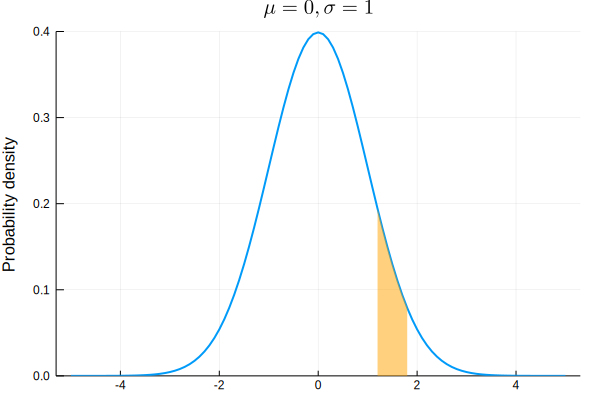

In [24]:
y = -5:0.1:5
fill_y = 1.2:0.1:1.8
plot(y, pdf.(Normal(), y), lw = 2, label = "", ylims = (0, 0.4),
    title = L"\mu=0, \sigma=1",
    ylabel = "Probability density")

plot!(fill_y, pdf.(Normal(), fill_y),
    label = "", fillrange = 0, fillalpha = 0.5, 
    linecolor = :transparent, fillcolor = :orange)

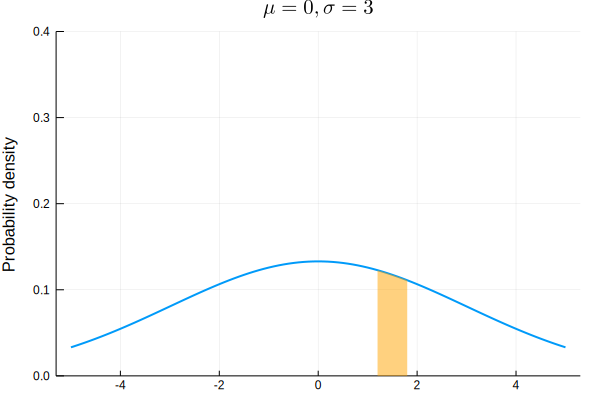

In [25]:
plot(y, pdf.(Normal(0, 3), y), lw = 2, label = "", ylims = (0, 0.4),
    title = L"\mu=0, \sigma=3",
    ylabel = "Probability density")
plot!(fill_y, pdf.(Normal(0, 3), fill_y), label = "", fillrange = 0, fillalpha = 0.5, 
    linecolor = :transparent, fillcolor = :orange)

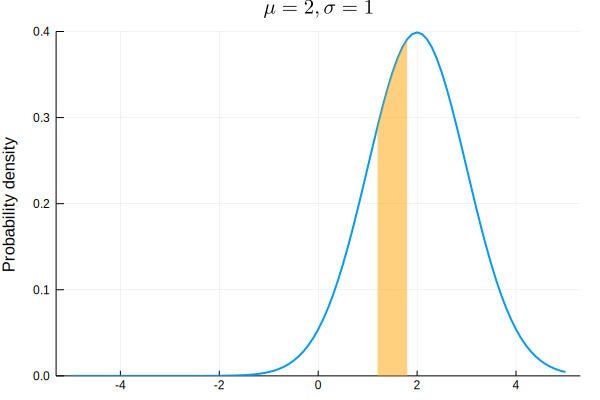

In [26]:
plot(y, pdf.(Normal(2, 1), y), lw = 2, label = "", ylims = (0, 0.4),
    title = L"\mu=2, \sigma=1",
    ylabel = "Probability density")
plot!(fill_y, pdf.(Normal(2, 1), fill_y), label = "", fillrange = 0, fillalpha = 0.5, 
    linecolor = :transparent, fillcolor = :orange)

$p(1.2 \le y \le 1.8 | \mu, \sigma)$を評価する

In [27]:
cdf(Normal(), 1.8) - cdf(Normal(), 1.2)

0.07913935110878245

近似

In [28]:
pdf.(Normal(), 1.5) * 0.6

0.07771055739953504

## 6.8 ガンマ分布のGLM
https://juliastats.github.io/Distributions.jl/latest/univariate.html#Distributions.Gamma  

Distribution.jlのパラメトライズ
\begin{equation}
f(x; \alpha, \theta) = \frac{x^{\alpha-1} e^{-x/\theta}}{\Gamma(\alpha) \theta^\alpha},
\quad x > 0
\end{equation}
は本文のもの
\begin{equation}
p(y \mid s, r) = \frac{r^s}{\Gamma (s)}y^{s-1}\exp (-ry)
\end{equation}
と異なっていることに注意(対応は$\alpha = s, \theta = 1/r).$

In [29]:
d = CSV.read("data/section6c.csv");

In [30]:
d.logx = log.(d.x)
d

,x,y,logx
,Float64⍰,Float64⍰,Float64
1,0.001,0.000887358,-6.90776
2,0.0173061,0.0234652,-4.05669
3,0.0336122,0.0698756,-3.39286
4,0.0499184,0.0343403,-2.99737
5,0.0662245,0.0265204,-2.7147
6,0.0825306,0.159215,-2.49459
7,0.0988367,0.165078,-2.31429
8,0.115143,0.124003,-2.16158
9,0.131449,0.0596455,-2.02914


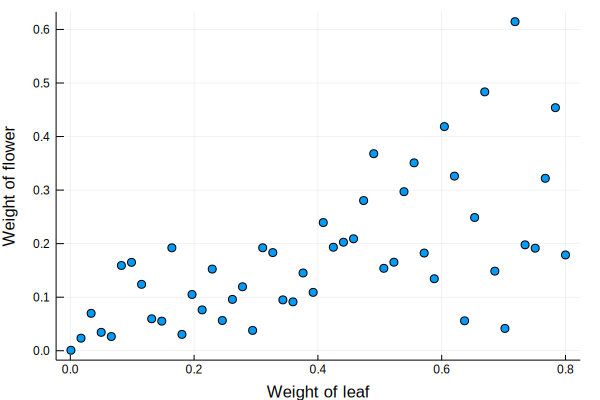

In [31]:
plot(d.x, d.y, seriestype = :scatter, 
    label = "",
    xlabel = "Weight of leaf", ylabel = "Weight of flower")

### 確率密度関数のプロット
オレンジの領域の面積は$1.2 \le y \le 1.8$となる確率を表す

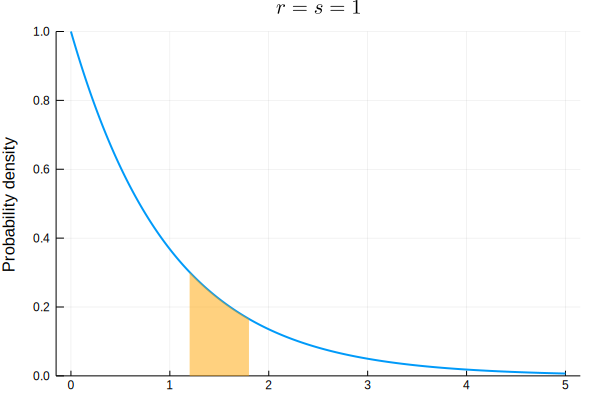

In [32]:
y = 0:0.01:5
fill_y = 1.2:0.05:1.8
plot(y, pdf.(Gamma(1, 1), y), lw = 2, label = "", ylims = (0, 1.0),
    title = L"r=s=1",
    ylabel = "Probability density")

plot!(fill_y, pdf.(Gamma(1, 1), fill_y),
    label = "", fillrange = 0, fillalpha = 0.5, 
    linecolor = :transparent, fillcolor = :orange)

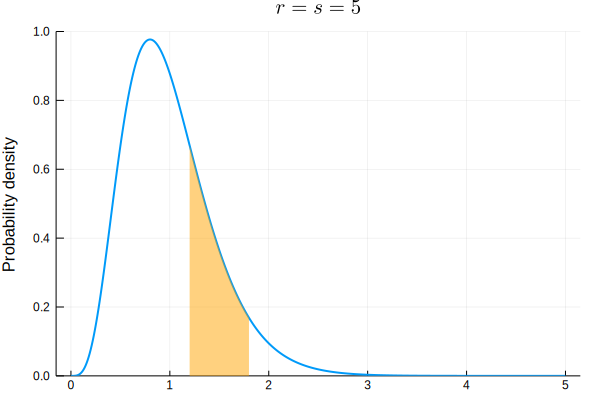

In [33]:
plot(y, pdf.(Gamma(5, 1 / 5), y), lw = 2, label = "", ylims = (0, 1.0),
    title = L"r=s=5",
    ylabel = "Probability density")

plot!(fill_y, pdf.(Gamma(5, 1 / 5), fill_y),
    label = "", fillrange = 0, fillalpha = 0.5, 
    linecolor = :transparent, fillcolor = :orange)

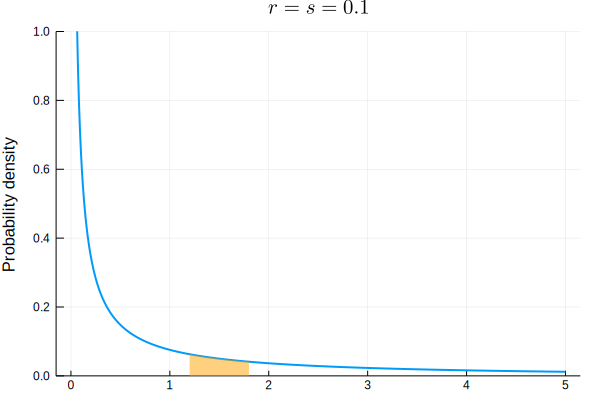

In [34]:
plot(y, pdf.(Gamma(0.1, 1 / 0.1), y), lw = 2, label = "", ylims = (0, 1.0),
    title = L"r=s=0.1",
    ylabel = "Probability density")

plot!(fill_y, pdf.(Gamma(0.1, 1 / 0.1), fill_y),
    label = "", fillrange = 0, fillalpha = 0.5, 
    linecolor = :transparent, fillcolor = :orange)

### GLM

In [35]:
gamma_result = glm(@formula(y ~ logx), d, Gamma(), LogLink())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Gamma{Float64},LogLink},DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + logx

Coefficients:
             Estimate Std.Error  z value Pr(>|z|)
(Intercept)  -1.04019  0.118773 -8.75784   <1e-17
logx         0.683346 0.0683808  9.99324   <1e-22


http://hosho.ees.hokudai.ac.jp/~kubo/ce/GlmGamma.html

In [36]:
mm = gamma_result.model

GeneralizedLinearModel{GlmResp{Array{Float64,1},Gamma{Float64},LogLink},DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}}:

Coefficients:
     Estimate Std.Error  z value Pr(>|z|)
x1   -1.04019  0.118773 -8.75784   <1e-17
x2   0.683346 0.0683808  9.99324   <1e-22



推定された結果、ガンマ分布を使って評価された50%と90%区間の予測を示す  

In [37]:
xx = DataFrame(x = 0.01:0.01:0.8)
xx.logx = log.(xx.x)
mm_mean = predict(gamma_result, xx)

80-element Array{Union{Missing, Float64},1}:
 0.015189956430233952
 0.024392946487179663
 0.03218070647130134 
 0.039171661950398784
 0.045624182637674406
 0.05167771576432363 
 0.05741840842504066 
 0.06290421293560308 
 0.0681764871247959  
 0.07326605910382868 
 0.07819669004498406 
 0.08298718702772558 
 0.08765276099990227 
 ⋮                   
 0.2742377629545271  
 0.2769475030845767  
 0.27964501257089025 
 0.28233051773365203 
 0.2850042376263437  
 0.28766638436521996 
 0.29031716343960445 
 0.29295677400436027 
 0.295585409155782   
 0.2982032561920508  
 0.30081049685930217 
 0.30340730758427464 

Dispersion parameter  
http://juliastats.github.io/GLM.jl/stable/api/#GLM.dispersion

In [38]:
mm_phi = GLM.dispersion(mm, true)

0.3251083086147989

In [39]:
mm_alpha = 1 / mm_phi
mm_theta = mm_mean .* mm_phi

80-element Array{Float64,1}:
 0.004938381042965848
 0.00793034957457828 
 0.010462215050914093
 0.012735032762324823
 0.014832800849267   
 0.016800854765215586
 0.018667201646418687
 0.020450682272239073
 0.02216474241644101 
 0.02381940455411763 
 0.02542239363980045 
 0.02697982401128384 
 0.028496640874095435
 ⋮                   
 0.08915697527245246 
 0.09003793430291854 
 0.0909149170494863  
 0.0917879970907281  
 0.09265724564275082 
 0.0935227316663113  
 0.09438452196769594 
 0.09524268129380545 
 0.09609727242184958 
 0.09694835624402319 
 0.097795991847505   
 0.09864023659009358 

In [40]:
xs_gamma = Gamma.(mm_alpha, mm_theta)

80-element Array{Gamma{Float64},1}:
 Gamma{Float64}(α=3.075898011529565, θ=0.004938381042965848)
 Gamma{Float64}(α=3.075898011529565, θ=0.00793034957457828) 
 Gamma{Float64}(α=3.075898011529565, θ=0.010462215050914093)
 Gamma{Float64}(α=3.075898011529565, θ=0.012735032762324823)
 Gamma{Float64}(α=3.075898011529565, θ=0.014832800849267)   
 Gamma{Float64}(α=3.075898011529565, θ=0.016800854765215586)
 Gamma{Float64}(α=3.075898011529565, θ=0.018667201646418687)
 Gamma{Float64}(α=3.075898011529565, θ=0.020450682272239073)
 Gamma{Float64}(α=3.075898011529565, θ=0.02216474241644101) 
 Gamma{Float64}(α=3.075898011529565, θ=0.02381940455411763) 
 Gamma{Float64}(α=3.075898011529565, θ=0.02542239363980045) 
 Gamma{Float64}(α=3.075898011529565, θ=0.02697982401128384) 
 Gamma{Float64}(α=3.075898011529565, θ=0.028496640874095435)
 ⋮                                                          
 Gamma{Float64}(α=3.075898011529565, θ=0.08915697527245246) 
 Gamma{Float64}(α=3.075898011529565, θ=0.09003793

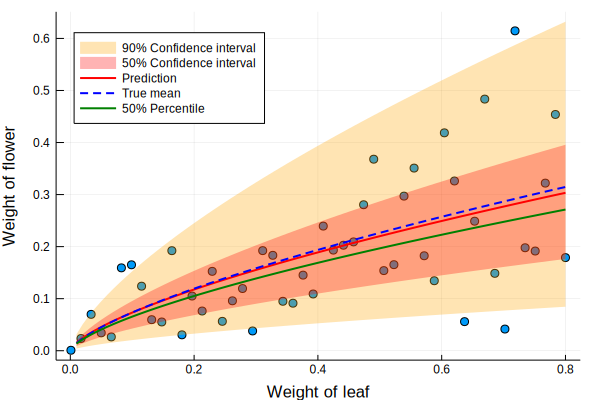

In [41]:
plot(d.x, d.y, seriestype = :scatter, 
    label = "", legend = :topleft,
    xlabel = "Weight of leaf", ylabel = "Weight of flower")

function g_quantile(r)
   return quantile.(xs_gamma, r)
end

plot!(xx.x, g_quantile(0.95), lw = 0, 
    fillrange = g_quantile(0.05), fillalpha = 0.3, fillcolor = :orange,
    label = "90% Confidence interval")
plot!(xx.x, g_quantile(0.75), lw = 0, fillcolor = :red,
    fillrange = g_quantile(0.25), fillalpha = 0.3,
    label = "50% Confidence interval")
plot!(xx.x, mm_mean, lw = 2, label = "Prediction", linecolor = :red)
plot!(xx.x, mean.(Gamma.(1 / 0.3, exp.([ones(80) xx.logx] * [-1, 0.7]) .* 0.3)), 
    lw = 2, label = "True mean", linestyle = :dash, linecolor = :blue)
plot!(xx.x, g_quantile(0.5), lw = 2, label = "50% Percentile", linecolor = :green)